In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.io as pio
pio.templates.default = 'plotly_white'
import logging
import logzero
logzero.loglevel(logging.INFO)

In [2]:
dir_fname = 'work'
import os
os.chdir(dir_fname)

## Codes for generating random sequences

市川さんのプログラム`rand_seq`には以下のようなあまり現実的ではない性質があったので自分で書く。

- 生成したユニット配列自身がタンデムリピートになり得る
- 連続した insertion が入らない
- 1つのリピート配列の中に必ず「リピート長 * エラー率」の数のエラーが入っている (これは意図しているならば大丈夫)

一言で言うと、指定された長さの文字列を受け取るような edit script を {=, X, I, D} の相対確率に基づいてランダムに生成する。そして、真の配列 (= ユニット配列 * コピー数) にその edit script を適用したものが観測配列となる。

In [3]:
import random
random.seed(111)

In [4]:
nucleotides = ('a', 'c', 'g', 't')
edit_ops = ('=', 'X', 'I', 'D')

def gen_random_edit_script(length, edit_weights):
    """Generate a random edit script whose query length is <length>
    based on the weights of the edit operations <edit_weights>."""
    s = ""
    query_len = 0   # length of the query string that <s> accepts
    while query_len < length:
        c = random.choices(edit_ops, weights=edit_weights)[0]
        s += c
        if c in set(['=', 'X', 'D']):
            query_len += 1
    return s

def apply_edit_script(true_seq, edit_script):
    """Mutate <true_seq> based on <edit_script>."""
    pos = 0   # on <true_seq>
    obs_seq = ""   # mutated sequence
    for edit_op in edit_script:
        if edit_op == '=':
            obs_seq += true_seq[pos]
        elif edit_op == 'X':
            obs_seq += random.choice(list(filter(lambda n: n != true_seq[pos], nucleotides)))
        elif edit_op == 'I':
            obs_seq += random.choice(nucleotides)

        if edit_op in set(['=', 'X', 'D']):
            pos += 1

    assert pos == len(true_seq), "Given edit script does not accept the sequence"
    return obs_seq

def mutate_seq(true_seq, edit_weights):
    """Insert random mutations to <true_seq> given a list of weights (= probabilities)
    for each edit operation, i.e., {=, X, I, D} in this order."""
    return apply_edit_script(true_seq, gen_random_edit_script(len(true_seq), edit_weights))

In [5]:
def is_tandem(seq):
    """Check if <seq> is tandemly repetitive or not,
    assuming it is error-free."""
    L = len(seq)
    for i in range(1, int(L / 2) + 1):
        if L % i != 0:
            continue
        if seq == seq[:i] * int(L / i):
            return True
    return False

def gen_random_non_tandem_repeat_seq(length):
    """Generate a NON tandem repeat sequence of <length> bp,
    which can be a unit sequence of a tandem repeat.
    """
    while True:
        seq = ''.join(random.choices(nucleotides, k=length))
        if not is_tandem(seq):
            return seq

In [6]:
def gen_random_tandem_repeats(n_seq, unit_len, n_copy, edit_weights, prefix_len, suffix_len):
    """Generate <n_seq> sequences where each consists of:
      [unique sequence of <prefix_len> bp] + [(unique sequence of <unit_len> bp) * <n_copy>] + [unique sequence of <suffix_len> bp]

    <edit_weights> is a list of weights for each edit operation, {=, X, I, D} in this order.
    Ex.) (85, 1, 11, 3) for PacBio CLR
    """
    def gen_tandem_repeat():
        pre_seq = gen_random_non_tandem_repeat_seq(prefix_len)
        suf_seq = gen_random_non_tandem_repeat_seq(suffix_len)
        unit_seq = gen_random_non_tandem_repeat_seq(unit_len)
        tr_seq = unit_seq * n_copy
        entire_seq = pre_seq + tr_seq + suf_seq
        return (mutate_seq(entire_seq, edit_weights), unit_seq)

    return [gen_tandem_repeat() for i in range(n_seq)]

In [6]:
edit_weights_pac_clr = (85, 1, 11, 3)

### Check some outputs

In [8]:
from BITS.seq.plot import DotPlot

In [10]:
gepard_root = '/work2/yoshihiko_s/software/gepard'
gepard_jar = f'{gepard_root}/dist/Gepard-1.40.jar'
gepard_mat = f'{gepard_root}/resources/matrices/edna.mat'
gepard = f'java -cp {gepard_jar} org.gepard.client.cmdline.CommandLine -matrix {gepard_mat}'

In [12]:
dp = DotPlot(gepard)

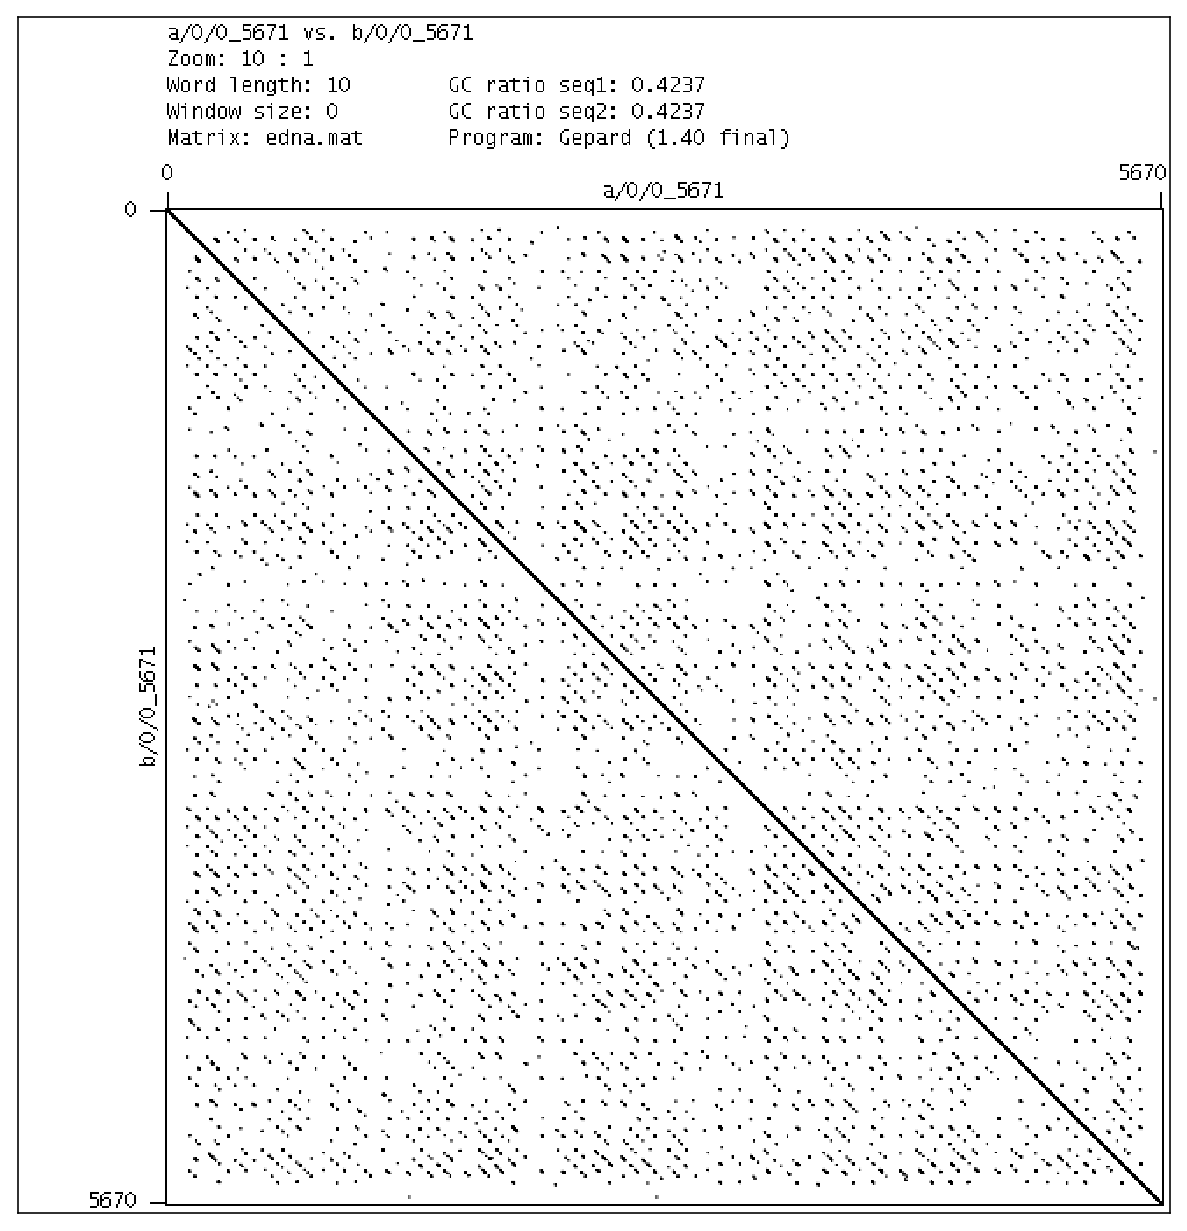

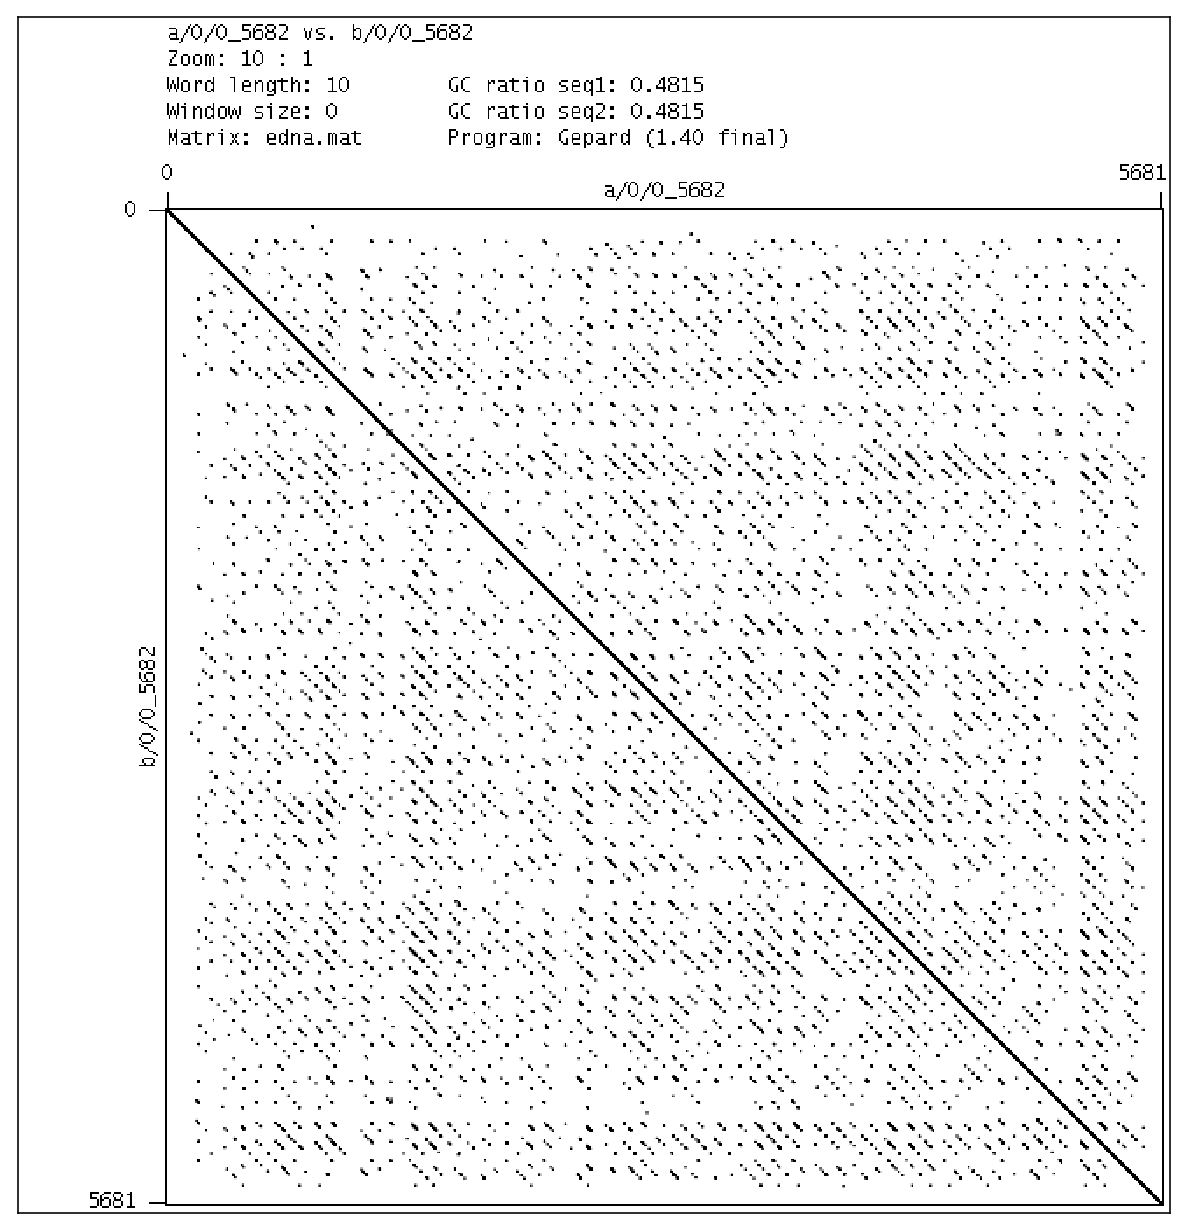

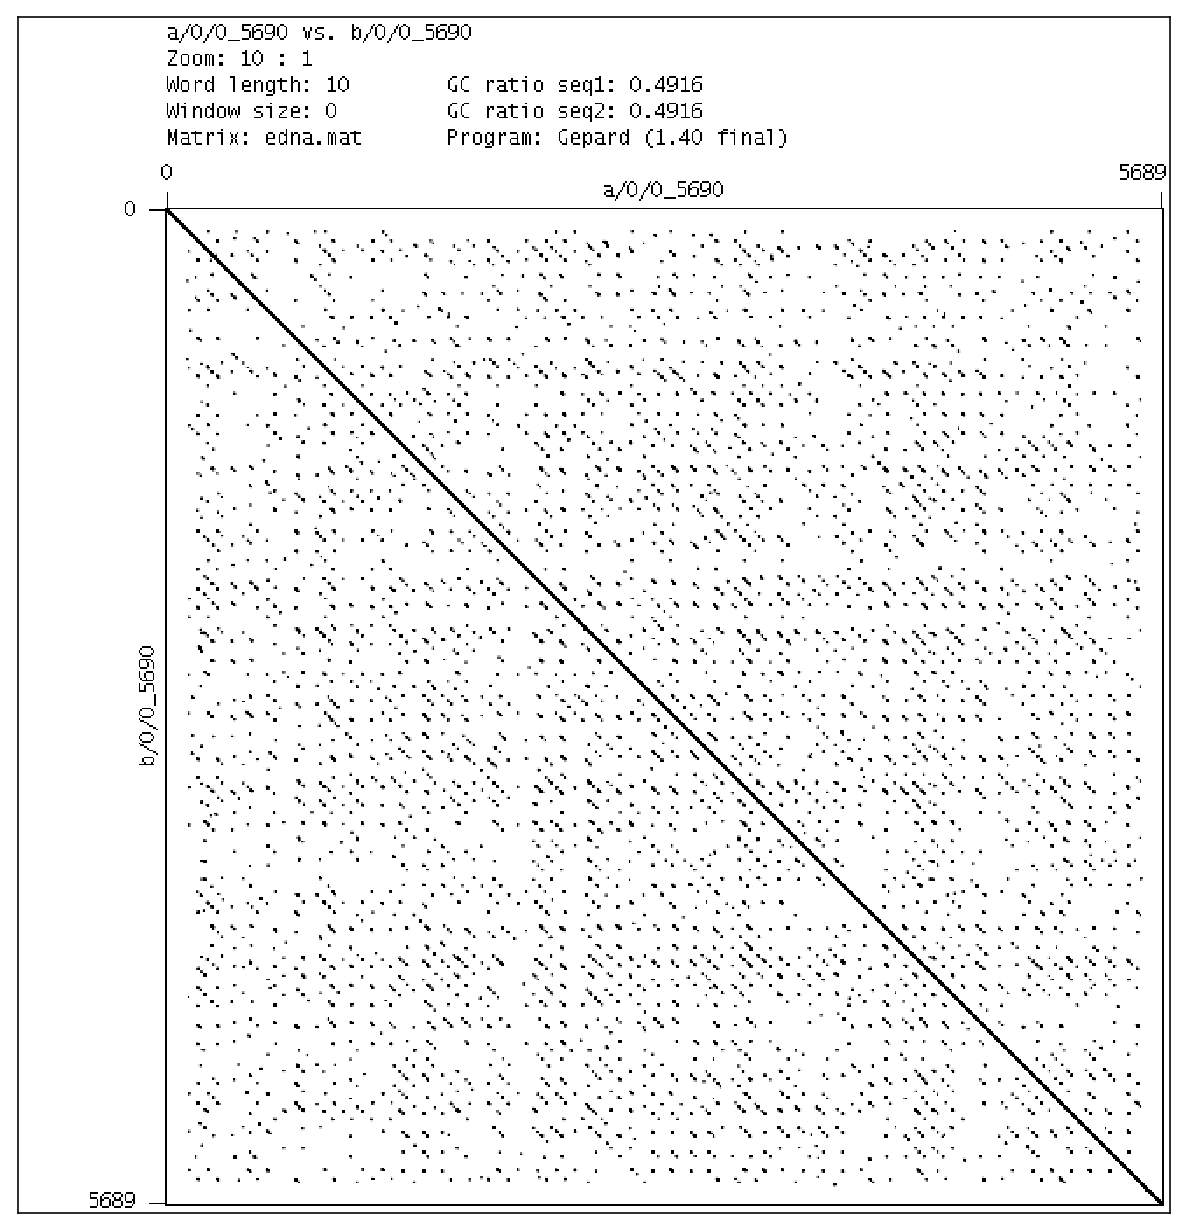

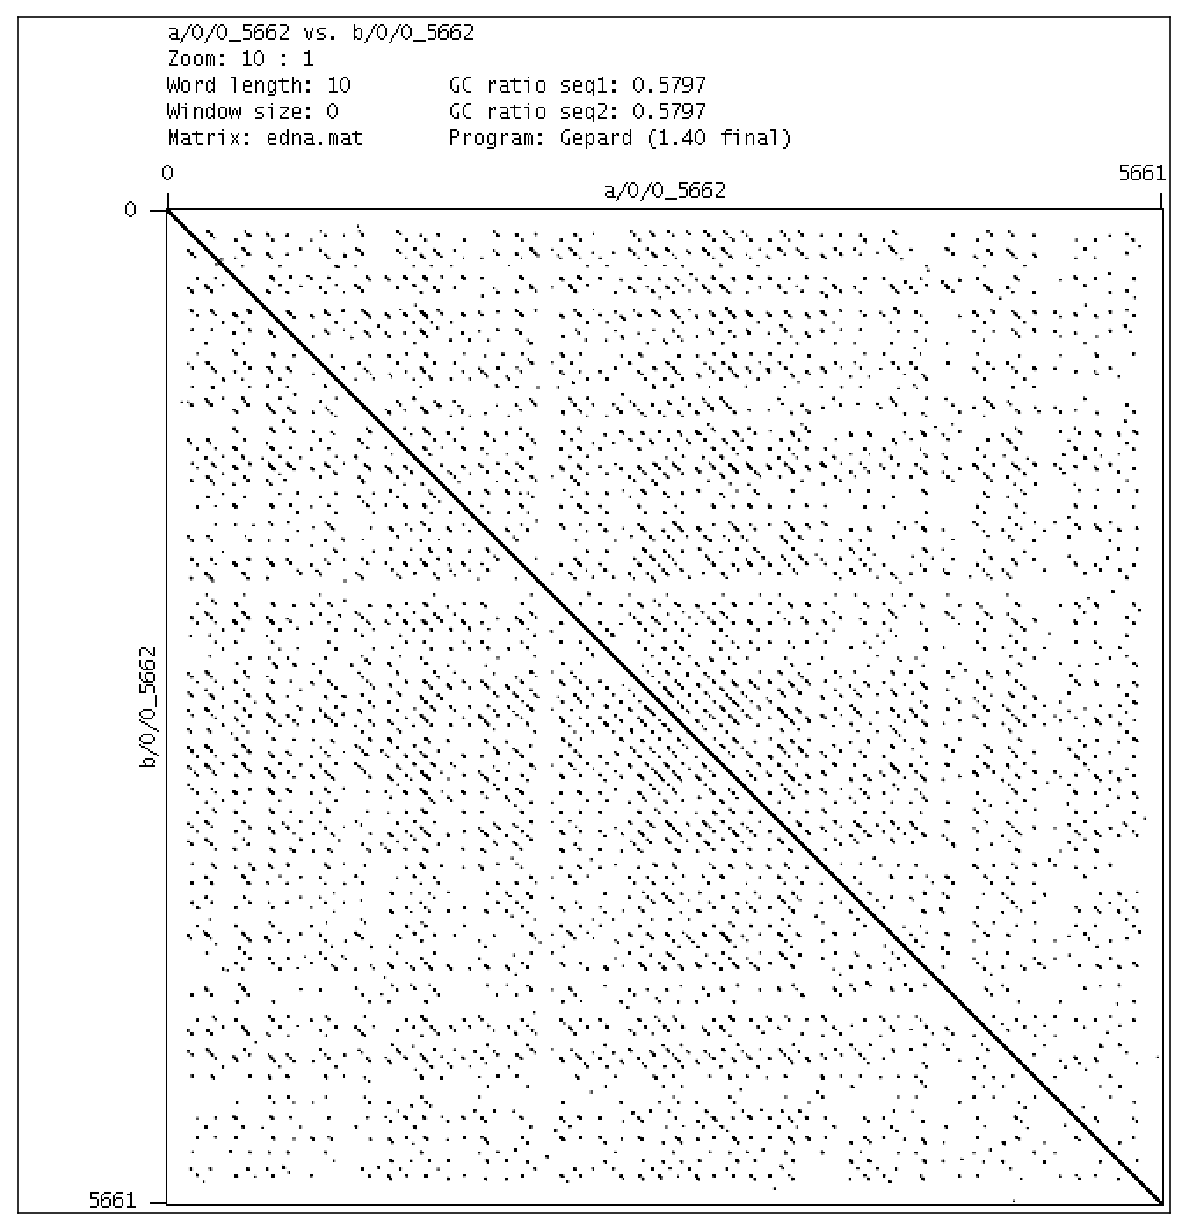

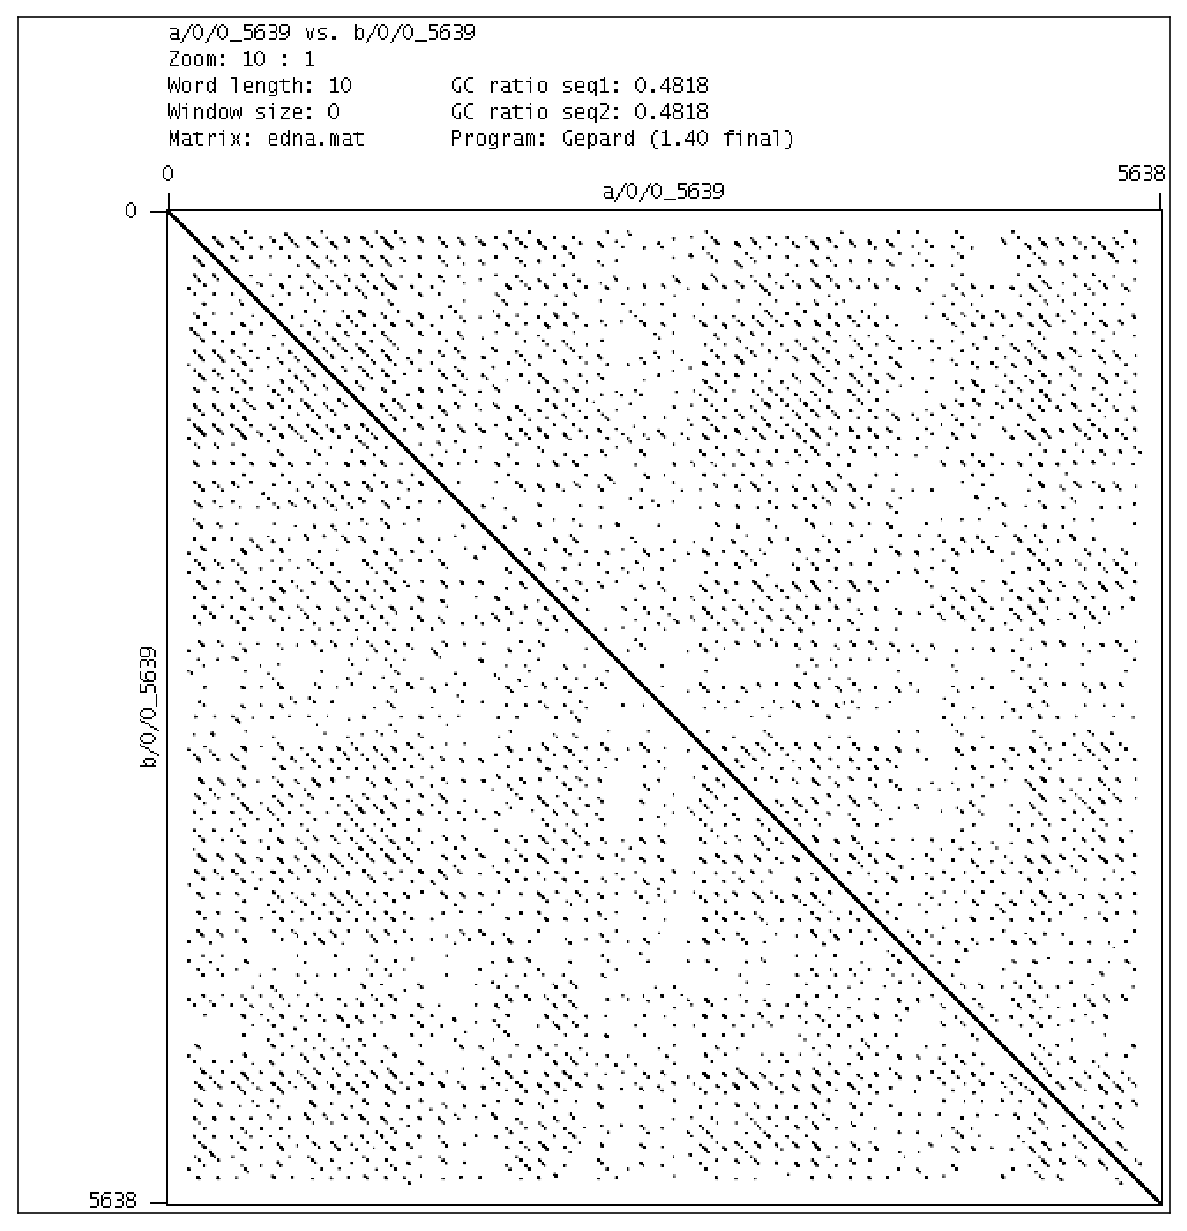

In [19]:
# Dot plot of 5 TR seqs
for tr_seq, unit_seq in gen_random_tandem_repeats(5, 100, 50, edit_weights_pac_clr, 100, 100):   # true seq length ~ 5200 bp
    dp.plot(tr_seq, tr_seq)

## Codes for running datander & datruf given a list of sequences

`.db`ではなく`List[str]`から始めて datander, datruf を実行できるようにする。可能ならば、datruf が切り出してきたユニット配列を Consed を使ってコンセンサスを取りたい。

In [7]:
import os
from BITS.seq.io import save_fasta, load_fasta
from BITS.util.proc import run_command
from vca.datander import DatanderRunner
from vca.datruf import DatrufRunner
from BITS.util.io import load_pickle
import consed
from BITS.seq.align import EdlibRunner

In [8]:
def seqs_to_fasta(seqs, out_prefix):
    """Given a list of strings, create a .fasta file."""
    save_fasta({f"seq/{str(i).zfill(10)}/0_{len(seq)}": seq for i, seq in enumerate(seqs, start=1)},
               out_fname=f"{out_prefix}.fasta",
               width=100)
    
def seqs_to_db(seqs, out_prefix):
    """Given a list of strings, create a .db file."""
    seqs_to_fasta(seqs, out_prefix)
    run_command('\n'.join([f"fasta2DB SEQS {out_prefix}.fasta",
                           f"DBsplit -s500 SEQS"]))

def run_datander(alignment_type, n_core, scheduler):
    r = DatanderRunner("SEQS", alignment_type, n_core, scheduler)
    r.run()
    r = DatrufRunner("SEQS.db", "TAN.SEQS.las", n_core=n_core, scheduler=scheduler)
    r.run()
    tr_reads = load_pickle("tr_reads.pkl")
    return [consed.consensus([tr_read.seq[unit.start:unit.end] for unit in tr_read.units], n_iter=3)
            for tr_read in tr_reads]

def do_benchmark(n_seq, unit_len, n_copy, edit_weights, prefix_len, suffix_len, alignment_type="CLR", n_core=1, scheduler=None):
    out_dir = f"L{unit_len}N{n_copy}M{edit_weights[0]}X{edit_weights[1]}I{edit_weights[2]}D{edit_weights[3]}P{prefix_len}S{suffix_len}R{n_seq}{alignment_type}"
    !(rm -rf {out_dir}; mkdir -p {out_dir})
    %cd {out_dir}

    tr_seqs, unit_seqs = zip(*gen_random_tandem_repeats(n_seq, unit_len, n_copy, edit_weights, prefix_len, suffix_len))
    seqs_to_db(tr_seqs, "seqs")
    seqs_to_fasta(unit_seqs, "true_units")
    
    cons_units = run_datander(alignment_type, n_core, scheduler)
    seqs_to_fasta(cons_units, "datruf_units")
    
    er = EdlibRunner("global", revcomp=False, cyclic=True)
    diffs = [er.align(unit_seqs[i], cons_units[i]).diff for i in range(n_seq)]
    
    %cd ..
    
    return diffs

In [124]:
do_benchmark(5, 100, 50, edit_weights_pac_clr, 0, 0)

/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L100N50M85X1I11D3P0S0R5CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work


[0.01, 0.0, 0.01, 0.03, 0.05]

In [78]:
!(ls -l)

total 36
drwxr-xr-x 2 yoshihiko_s users     6 Sep 13 00:19 datander
drwxr-xr-x 4 yoshihiko_s users  4096 Sep 13 00:35 L100N50M85X1I11D3P100S100R5CLR
-rw-r--r-- 1 yoshihiko_s users 28499 Sep 13 00:19 seqs.fasta
drwxr-xr-x 2 yoshihiko_s users    52 Sep 12 23:01 tmp
-rw-r--r-- 1 yoshihiko_s users   520 Sep 13 00:19 true_units.fasta


In [79]:
!(ls -l L100N50M85X1I11D3P100S100R5CLR/)

total 96
drwxr-xr-x 2 yoshihiko_s users    38 Sep 13 00:35 datander
drwxr-xr-x 2 yoshihiko_s users     6 Sep 13 00:29 datruf
-rw-r--r-- 1 yoshihiko_s users   565 Sep 13 00:35 datruf_units.fasta
-rw-r--r-- 1 yoshihiko_s users   145 Sep 13 00:35 SEQS.db
-rw-r--r-- 1 yoshihiko_s users 28651 Sep 13 00:35 seqs.fasta
-rw-r--r-- 1 yoshihiko_s users 15814 Sep 13 00:35 TAN.SEQS.las
-rw-r--r-- 1 yoshihiko_s users 39233 Sep 13 00:35 tr_reads.pkl
-rw-r--r-- 1 yoshihiko_s users   570 Sep 13 00:35 true_units.fasta


## Do the benchmark

具体的にどういうベンチマークが取りたいのか？よく考える

In [9]:
import plotly.graph_objects as go
from BITS.plot.plotly import make_layout, show_plot

### Error-free, no flanking regions

In [10]:
do_benchmark(10, 100, 30, (100, 0, 0, 0), 0, 0)

/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L100N30M100X0I0D0P0S0R10CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work


[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [15]:
show_plot([go.Violin(y=do_benchmark(100, unit_len, 30, (85, 1, 11, 3), 0, 0), box_visible=True, meanline_visible=True)
           for unit_len in (50, 100, 200)])

/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L50N30M85X1I11D3P0S0R100CLR/L50N30M85X1I11D3P0S0R100CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L50N30M85X1I11D3P0S0R100CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L50N30M85X1I11D3P0S0R100CLR/L100N30M85X1I11D3P0S0R100CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L50N30M85X1I11D3P0S0R100CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L50N30M85X1I11D3P0S0R100CLR/L200N30M85X1I11D3P0S0R100CLR
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L50N30M85X1I11D3P0S0R100CLR


In [185]:
!(ls -l)

total 0
drwxr-xr-x 2 yoshihiko_s users 52 Sep 13 01:01 tmp


In [179]:
%cd ..

[Errno 2] No such file or directory: '..'
/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/L200N10M100X0I0D0P0S0R10CLR


In [172]:
%cd work

/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work


In [184]:
%cd ~/work2/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work/

/work2/yoshihiko_s/project/CentromereAssembly/notebooks/benchmark_datander_datruf/work
